In [1]:
# Importing necessary libraries for data manipulation, financial analysis, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import datetime as dt
import warnings

# Importing libraries for financial data acquisition and analysis
import pandas_datareader
from pandas_datareader import data
import quantstats as qs
import yfinance as yf
import ta

# Importing libraries for portfolio optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, black_litterman, BlackLittermanModel

# Importing machine learning model for potential financial modeling
from sklearn.linear_model import LinearRegression

# Enabling Plotly offline mode for interactive plotting in notebooks
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Setting up environment configurations
warnings.filterwarnings("ignore")  # Hiding warnings for cleaner notebook presentation


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# --- Data Acquisition and Preprocessing ---


In [2]:
# Benchmark data: Downloading historical returns for the S&P 500 index
benchmark_returns = qs.utils.download_returns('^GSPC')
benchmark_returns = benchmark_returns.loc['2018-01-01':'2022-12-31']
benchmark_returns.index = benchmark_returns.index.tz_localize(None) if benchmark_returns.index.tz is not None else benchmark_returns.index



[*********************100%%**********************]  1 of 1 completed


In [3]:
# Selecting new tech stock symbols for analysis
tech_stocks = ['AAPL', "TSLA"]
tech_returns = {}

In [4]:
# Fetching and preparing daily returns for the chosen tech stocks
for symbol in tech_stocks:
    stock_return = qs.utils.download_returns(symbol)
    stock_return = stock_return.loc['2018-01-01':'2022-12-31']
    stock_return.index = stock_return.index.tz_localize(None) if stock_return.index.tz is not None else stock_return.index
    tech_returns[symbol] = stock_return


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
# Equal weight allocation for a simple initial portfolio
initial_weights = [0.5] * len(tech_stocks)

# Assembling the initial portfolio by aggregating weighted returns
initial_portfolio = sum(tech_returns[symbol] * weight for symbol, weight in zip(tech_stocks, initial_weights))


[Performance Metrics]



                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-01-02   2018-01-02
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          43.61%       425.37%
CAGR﹪                     5.13%        25.77%

Sharpe                     0.44         0.99
Prob. Sharpe Ratio         83.6%        98.58%
Smart Sharpe               0.42         0.94
Sortino                    0.61         1.44
Smart Sortino              0.58         1.37
Sortino/√2                 0.43         1.02
Smart Sortino/√2           0.41         0.97
Omega                      1.19         1.19

Max Drawdown               -33.92%      -54.42%
Longest DD Days            361          361
Volatility (ann.)          21.86%       43.19%
R^2                        0.45         0.45
Information Ratio          0.06         0.06
Calmar            

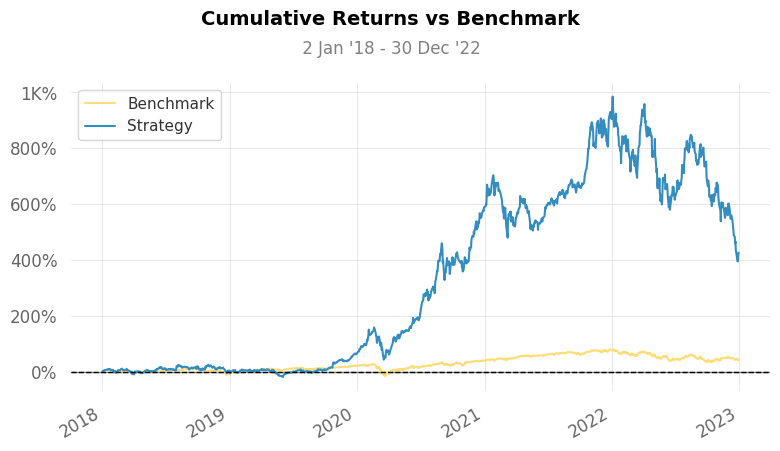

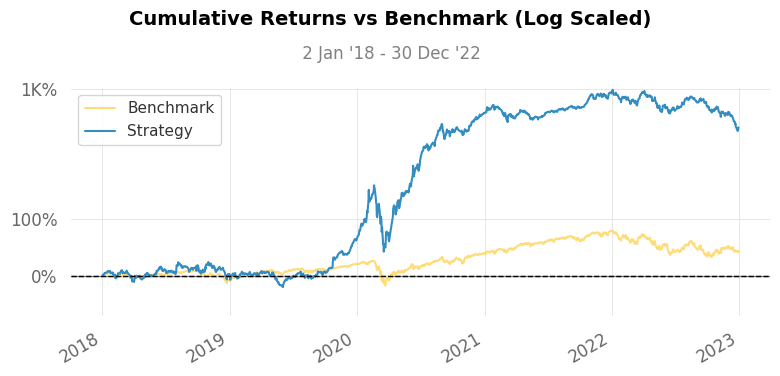

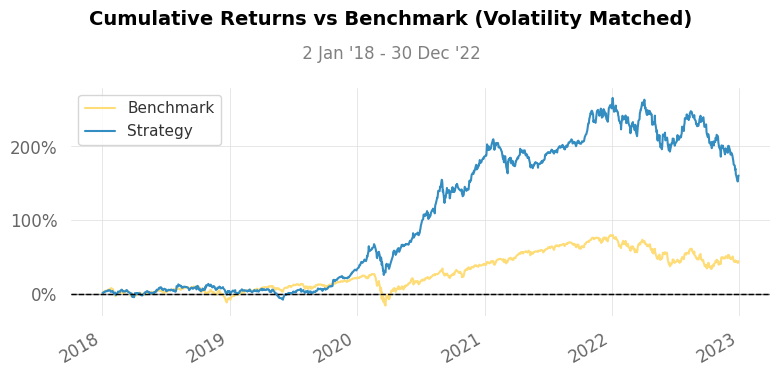

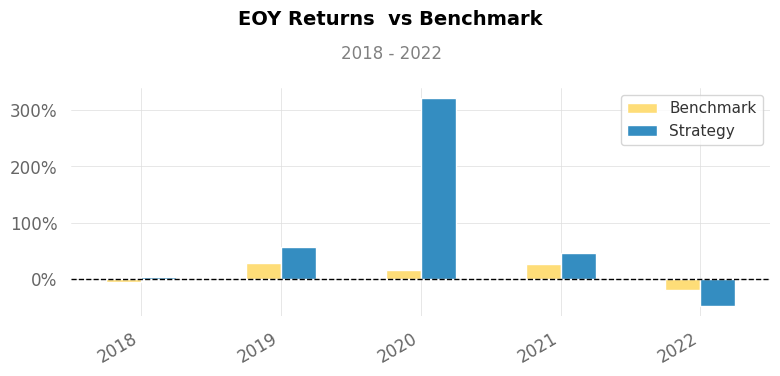

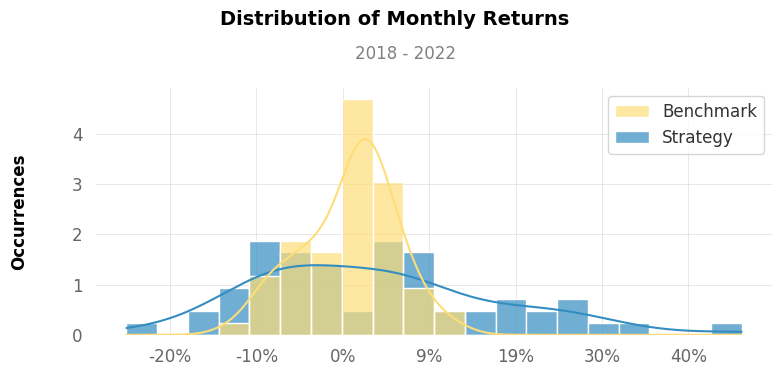

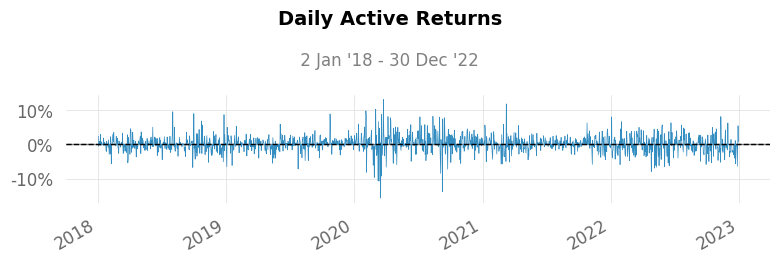

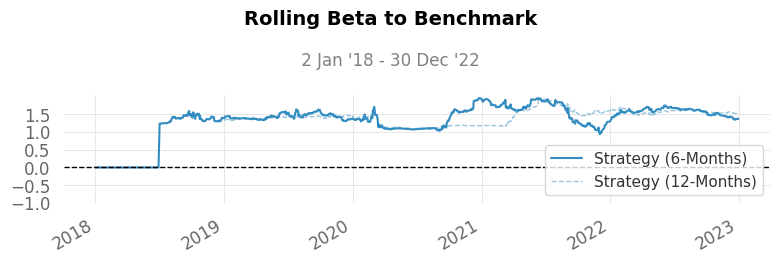

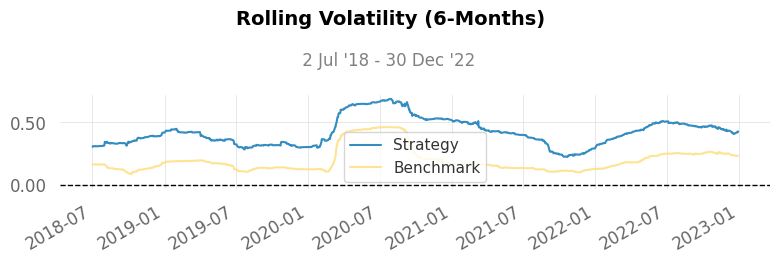

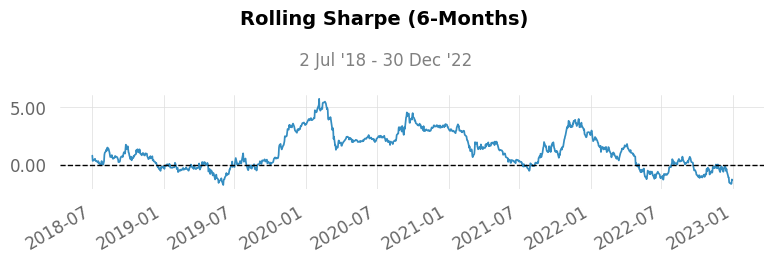

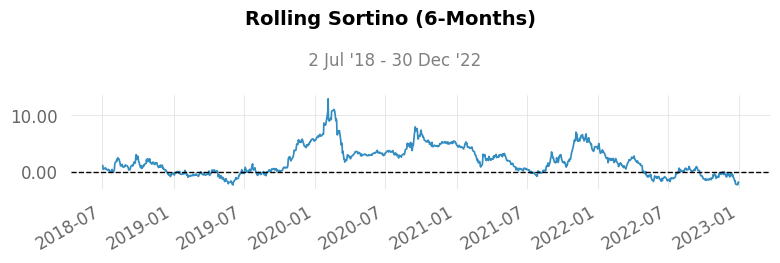

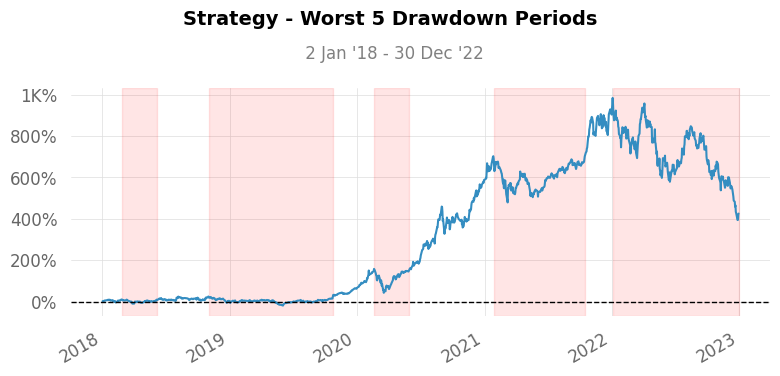

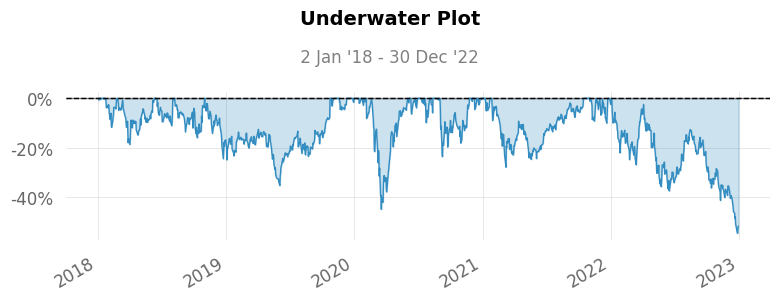

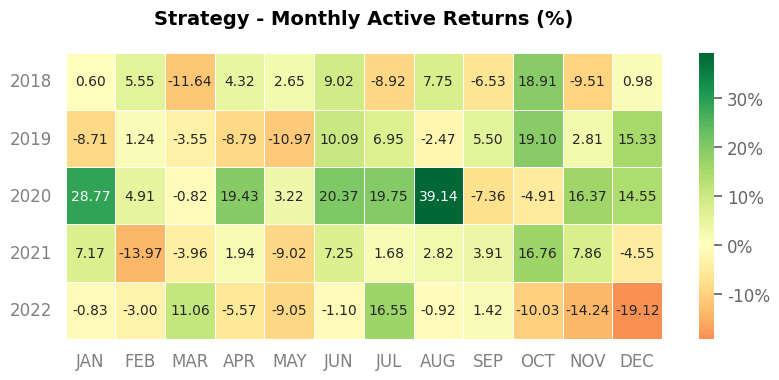

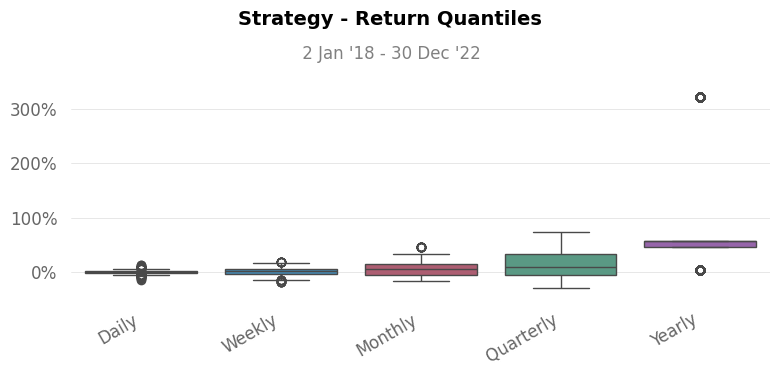

In [8]:
# Performance report for the initial portfolio
qs.reports.full(initial_portfolio, benchmark=benchmark_returns)


In [9]:
# Fetching adjusted close prices for optimization and further analysis
tech_prices = {}
for symbol in tech_stocks:
    tech_prices[symbol] = yf.download(symbol, start='2018-01-01', end='2022-12-31')['Adj Close']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [10]:
# Aggregating adjusted close prices into a single DataFrame
prices_df = pd.concat(tech_prices.values(), axis=1)
prices_df.columns = tech_stocks

# --- Portfolio Optimization ---


In [11]:
# Calculating expected returns and sample covariance for the optimization
expected_mu = expected_returns.mean_historical_return(prices_df)
sample_S = risk_models.sample_cov(prices_df)


In [12]:
# Efficient Frontier optimization for maximal Sharpe ratio
efficient_frontier = EfficientFrontier(expected_mu, sample_S)
sharpe_weights = efficient_frontier.max_sharpe()
optimized_weights = efficient_frontier.clean_weights()


In [13]:
# Displaying the optimized portfolio weights
print("Optimized Portfolio Weights:", optimized_weights)

Optimized Portfolio Weights: OrderedDict([('AAPL', 0.75393), ('TSLA', 0.24607)])


In [14]:
# Constructing the optimized portfolio with updated weights
optimal_weights_list = [0.75393, 0.24607]
optimized_portfolio = sum(tech_returns[symbol] * weight for symbol, weight in zip(tech_stocks, optimal_weights_list))


[Performance Metrics]



                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-01-02   2018-01-02
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          425.37%      321.33%
CAGR﹪                     25.77%       22.0%

Sharpe                     0.99         0.99
Prob. Sharpe Ratio         98.58%       98.54%
Smart Sharpe               0.91         0.91
Sortino                    1.44         1.42
Smart Sortino              1.33         1.31
Sortino/√2                 1.02         1.01
Smart Sortino/√2           0.94         0.93
Omega                      1.19         1.19

Max Drawdown               -54.42%      -43.15%
Longest DD Days            361          361
Volatility (ann.)          43.19%       35.74%
R^2                        0.9          0.9
Information Ratio          -0.03        -0.03
Calmar             

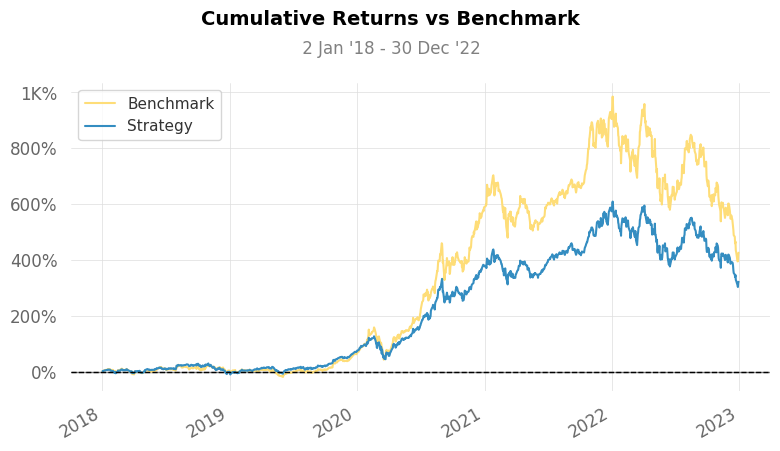

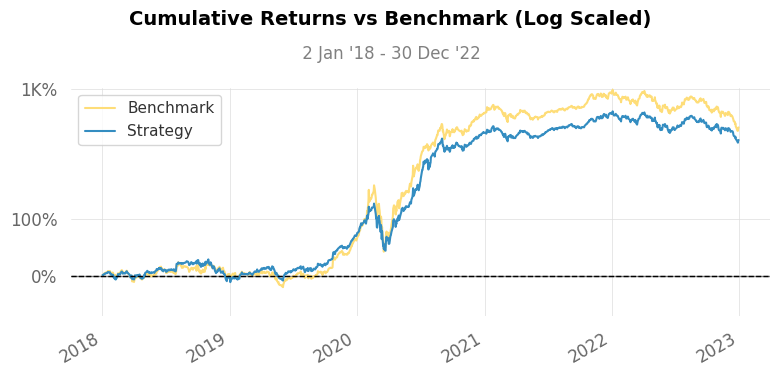

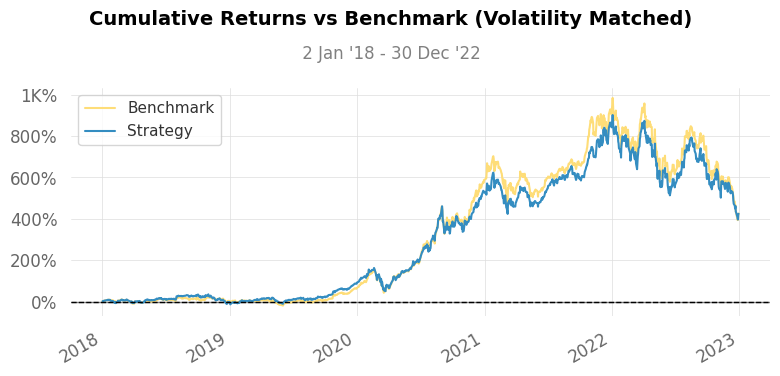

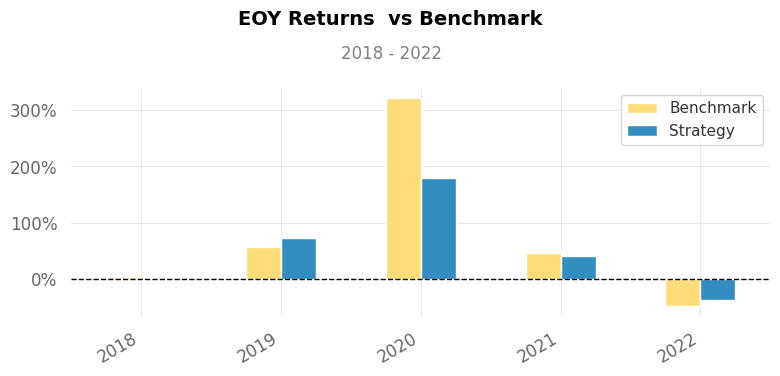

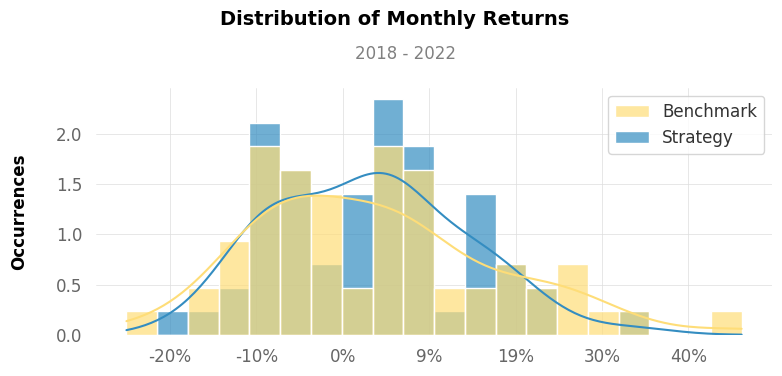

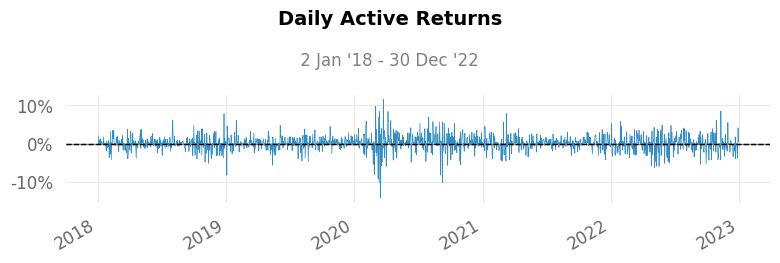

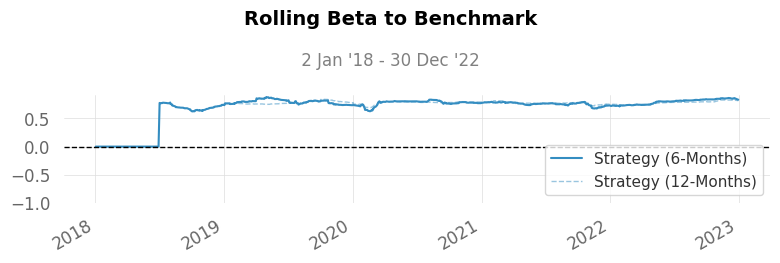

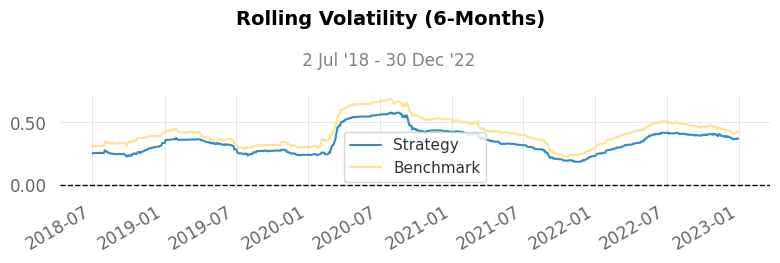

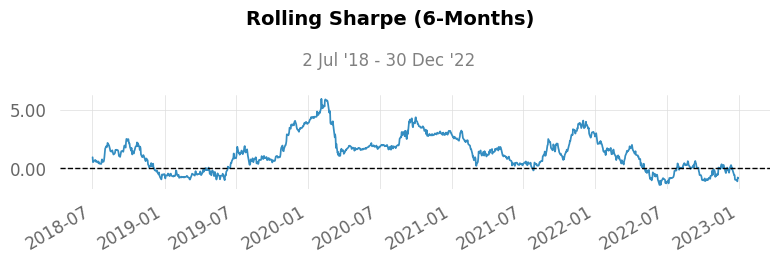

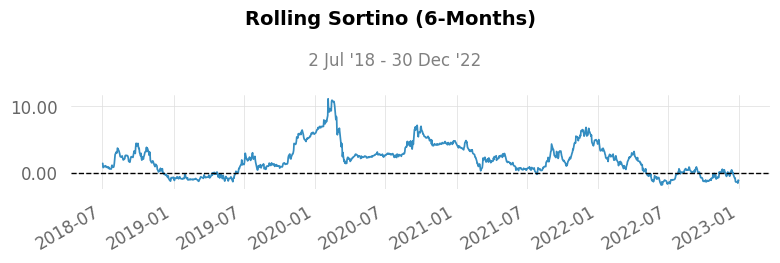

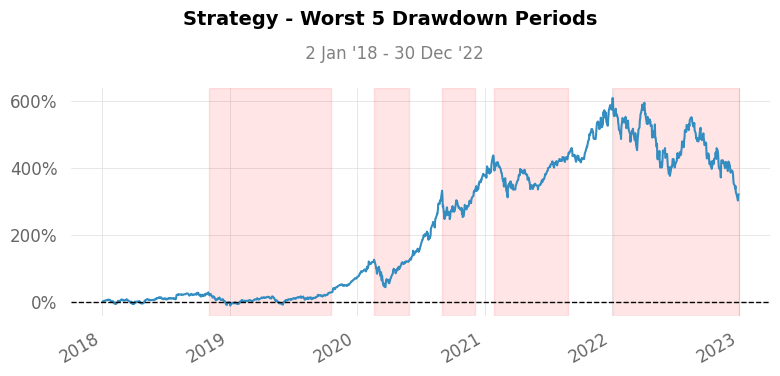

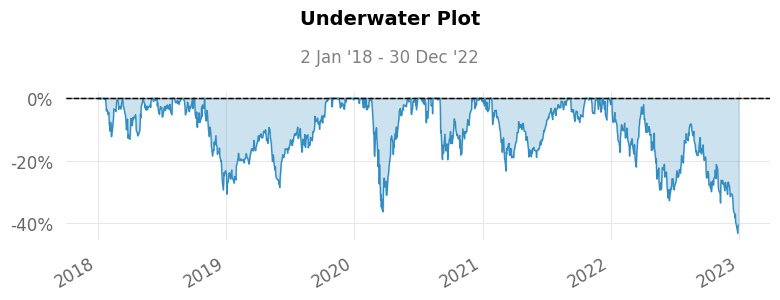

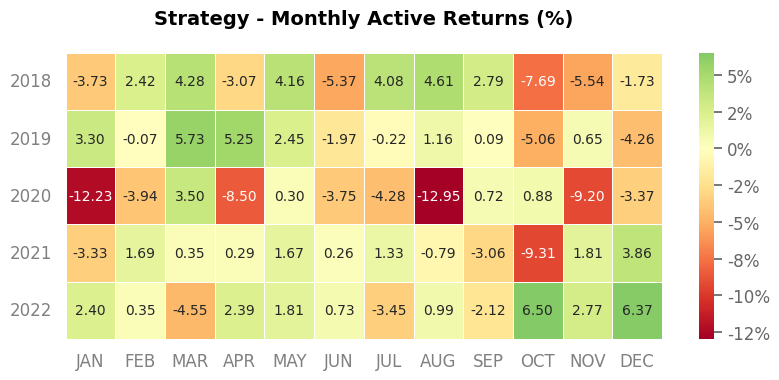

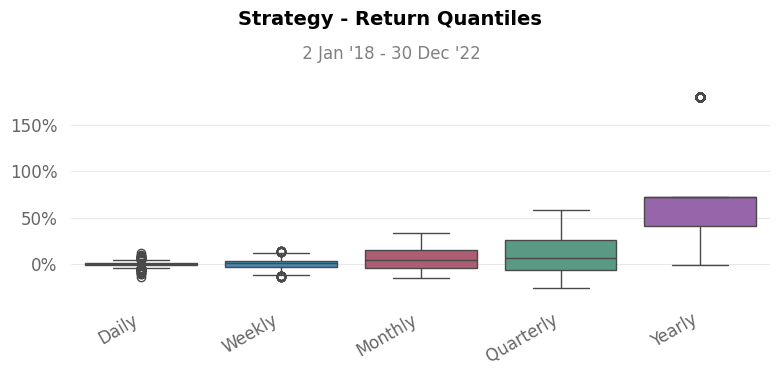

In [15]:
# Evaluating the optimized portfolio against the initial one
qs.reports.full(optimized_portfolio, benchmark=initial_portfolio)


# --- Advanced Optimization with Black-Litterman Model ---

In [16]:
# Market capitalization data for Black-Litterman model input
market_caps_bl = {symbol: yf.Ticker(symbol).info["marketCap"] for symbol in tech_stocks}

# Market-implied risk aversion using S&P 500 index prices
sp500_prices = yf.download("^GSPC", start='2018-01-01', end='2022-12-31')['Adj Close']
delta_market = black_litterman.market_implied_risk_aversion(sp500_prices)


[*********************100%%**********************]  1 of 1 completed


In [18]:
# Investor's views and confidences for Black-Litterman model
views_Q = np.array([0.06, 0.04])  # Hypothetical views on returns
views_P = np.eye(len(tech_stocks))  # Direct mapping of views to tech stocks
views_confidence = [0.6, 0.5]  # Confidence levels in the views


In [19]:
# Initializing Black-Litterman model with market data and investor's views
black_litterman_model = BlackLittermanModel(sample_S, pi=expected_mu, Q=views_Q, P=views_P, omega='idzorek', view_confidences=views_confidence)

# Expected returns from the Black-Litterman model
bl_expected_returns = black_litterman_model.bl_returns()


In [20]:
# Portfolio optimization based on Black-Litterman model returns
efficient_frontier_bl = EfficientFrontier(bl_expected_returns, sample_S)
efficient_frontier_bl.max_sharpe()
bl_weights = efficient_frontier_bl.clean_weights()
bl_weights

OrderedDict([('AAPL', 0.79112), ('TSLA', 0.20888)])

In [21]:
# Constructing the Black-Litterman optimized portfolio
# Note: Update 'bl_optimal_weights' based on 'bl_weights' output for actual use
bl_optimal_weights = [0.79112, 0.20888]  # Example weights, should be replaced with actual BL weights
bl_optimized_portfolio = sum(tech_returns[symbol] * weight for symbol, weight in zip(tech_stocks, bl_optimal_weights))


[Performance Metrics]



                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-01-02   2018-01-02
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          425.37%      304.27%
CAGR﹪                     25.77%       21.3%

Sharpe                     0.99         0.97
Prob. Sharpe Ratio         98.58%       98.45%
Smart Sharpe               0.9          0.89
Sortino                    1.44         1.41
Smart Sortino              1.32         1.29
Sortino/√2                 1.02         0.99
Smart Sortino/√2           0.93         0.91
Omega                      1.19         1.19

Max Drawdown               -54.42%      -41.37%
Longest DD Days            361          361
Volatility (ann.)          43.19%       35.04%
R^2                        0.86         0.86
Information Ratio          -0.03        -0.03
Calmar            

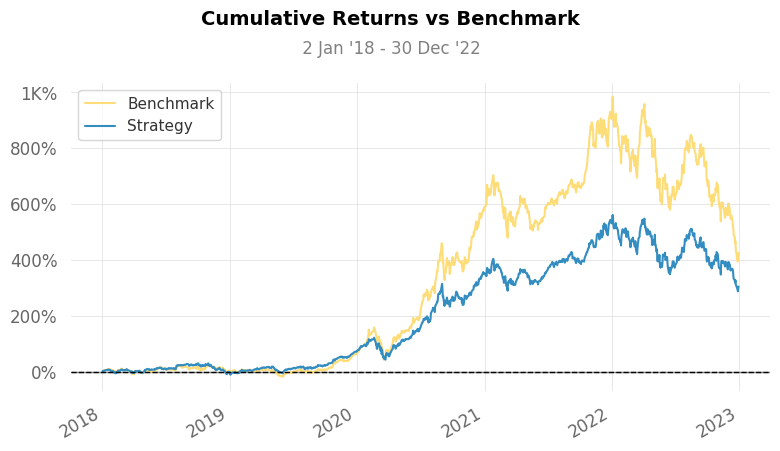

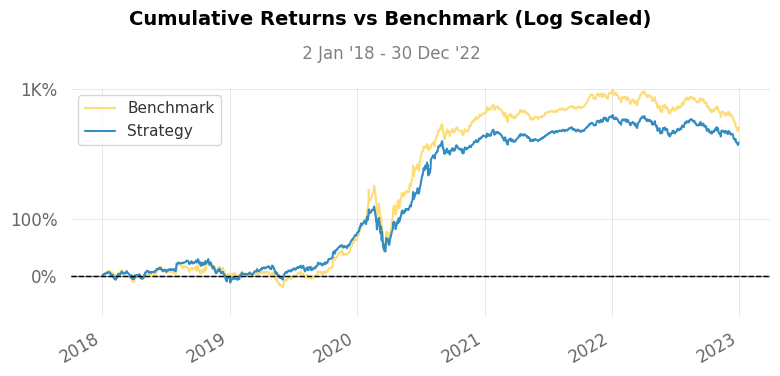

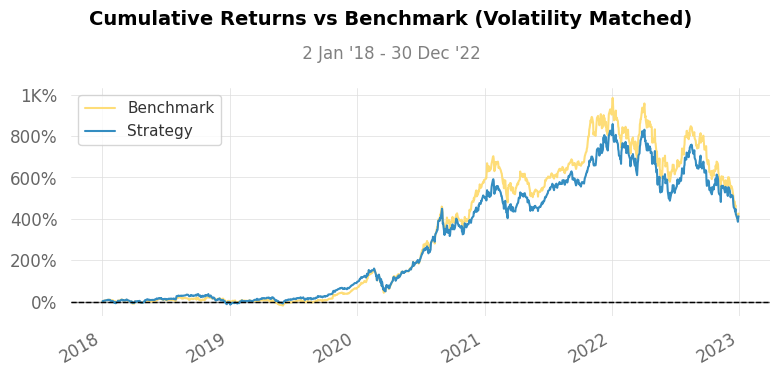

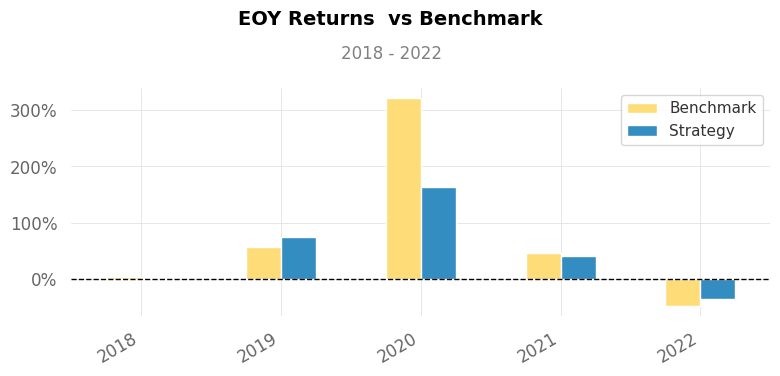

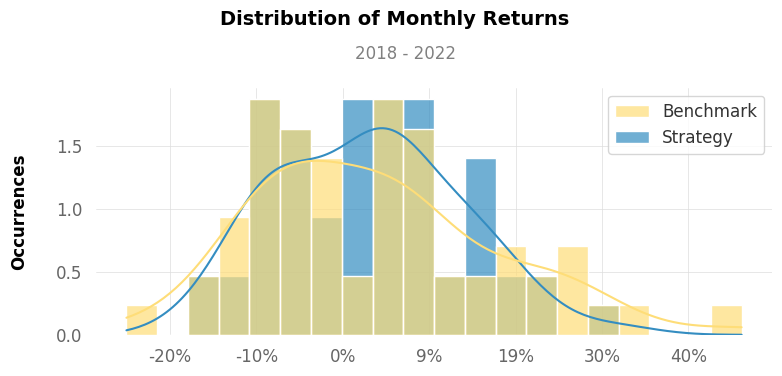

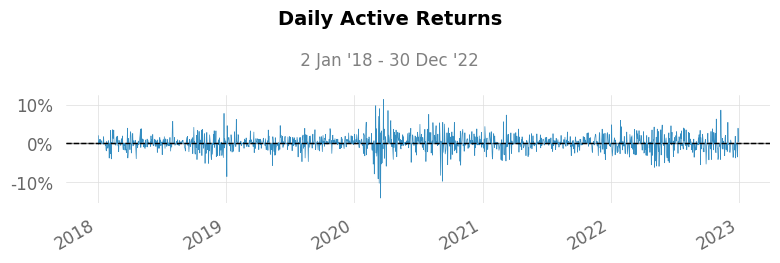

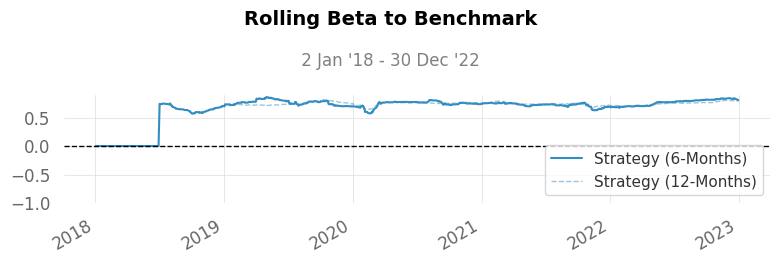

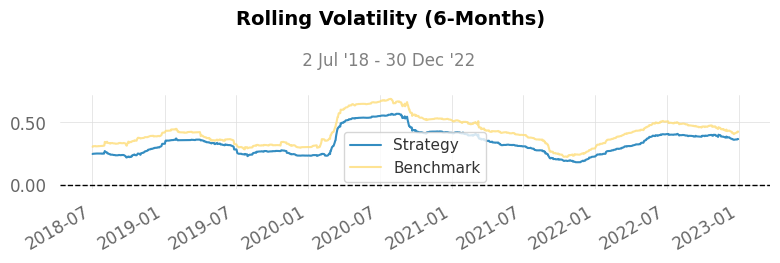

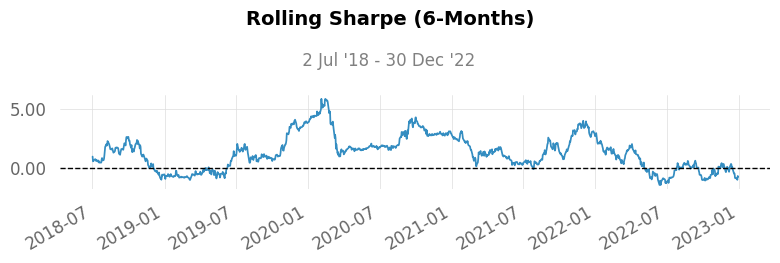

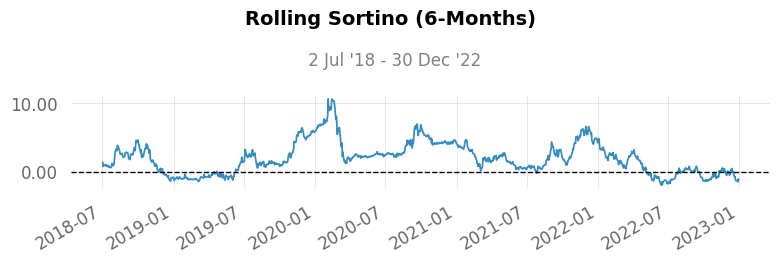

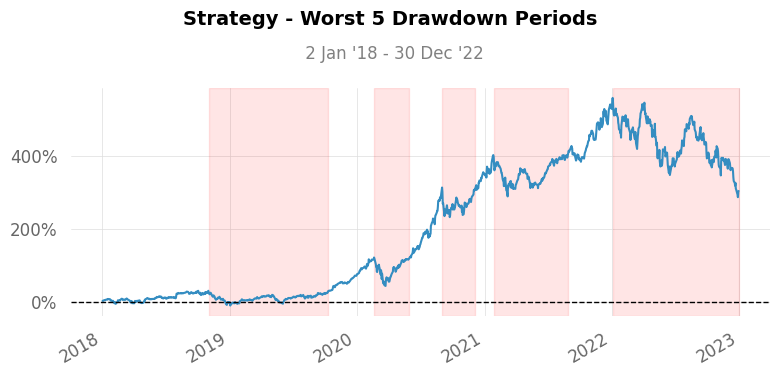

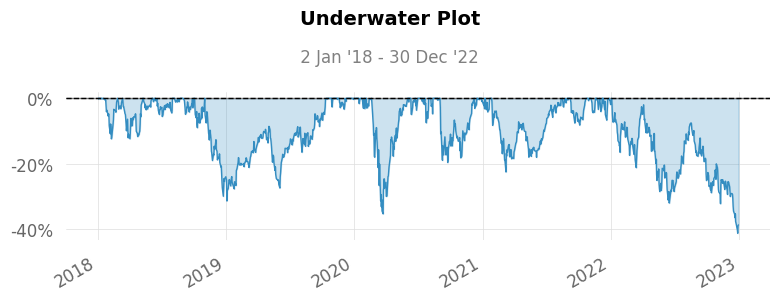

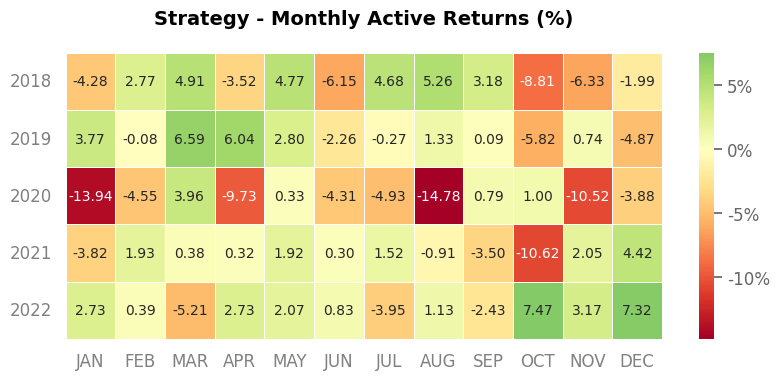

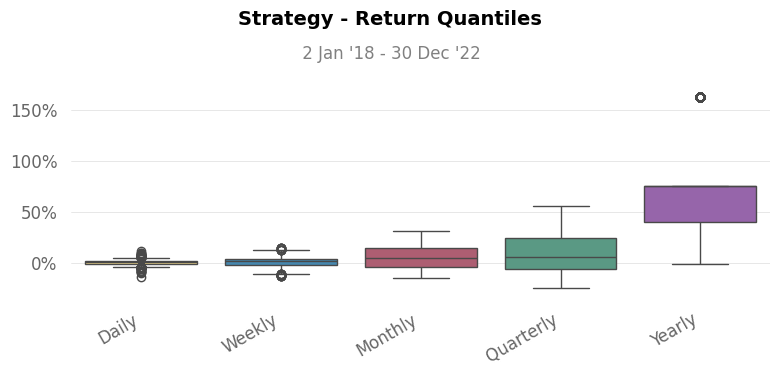

In [22]:
# Performance evaluation of the Black-Litterman optimized portfolio against the initial one
qs.reports.full(bl_optimized_portfolio, benchmark=initial_portfolio)